In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [2]:
trips = pd.read_csv('2015_trip_data.csv',
                    parse_dates=['starttime', 'stoptime'],
                    infer_datetime_format=True)

In [3]:
ind = pd.DatetimeIndex(trips.starttime)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour

In [4]:
hourly = trips.pivot_table('trip_id', aggfunc='count',
                           index=['usertype', 'date'], columns='hour').fillna(0)
hourly.head()

hour                      0   1   2   3   4   5   6   7   8   9  ...  14  15  \
usertype      date                                               ...           
Annual Member 2014-10-13   0   0   0   0   0   0   0   0   0   0 ...  32  23   
              2014-10-14   0   0   0   0   0   1   4  16  28  13 ...  13  16   
              2014-10-15   1   0   0   0   0   0   5   7  11  16 ...   7  10   
              2014-10-16   2   1   0   0   0   2   6   8  27  19 ...   8  10   
              2014-10-17   1   0   1   0   0   1   4  13  20  19 ...   3   5   

hour                      16  17  18  19  20  21  22  23  
usertype      date                                        
Annual Member 2014-10-13  23  28  21   8  11   9   3   1  
              2014-10-14  19  28  25  14   8  10   1   2  
              2014-10-15  32  33  15  15   9   9   2   1  
              2014-10-16  27  40  20  17   6   6   3   4  
              2014-10-17  17  17  20  10   5  10   2   1  

[5 rows x 24 columns]

In [5]:
from sklearn.decomposition import PCA
data = hourly[np.arange(24)].values
data_pca = PCA(2).fit_transform(data)
hourly['pca1'], hourly['pca2'] = data_pca.T

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


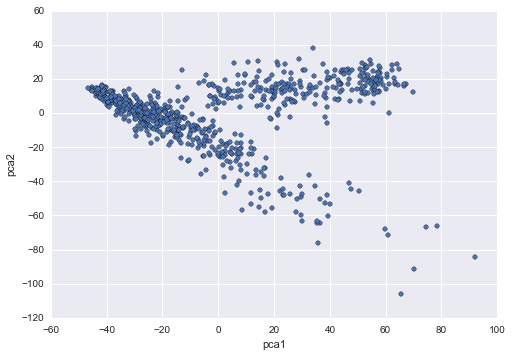

In [6]:
hourly.plot('pca1', 'pca2', kind='scatter');

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


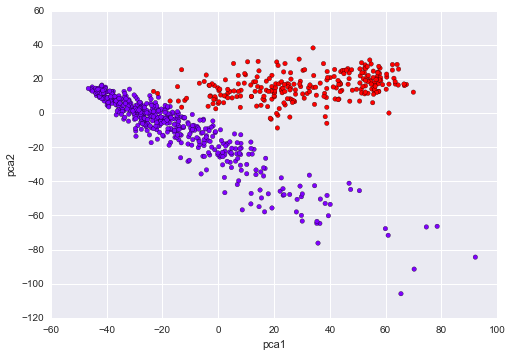

In [7]:
from sklearn.mixture import GMM
gmm = GMM(3, covariance_type='full', random_state=2)
data = hourly[['pca1', 'pca2']]
gmm.fit(data)
hourly['cluster'] = (gmm.predict(data) == 0).astype(int)

hourly.plot('pca1', 'pca2', c='cluster', kind='scatter', 
            cmap='rainbow', colorbar=False);

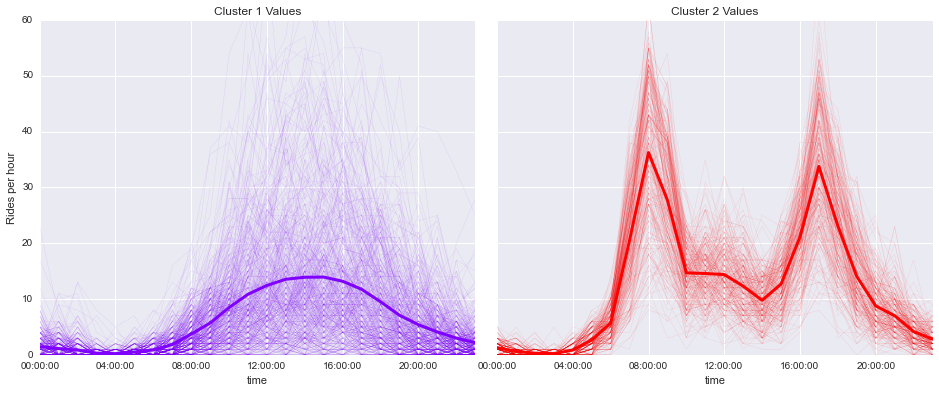

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)
times = pd.date_range('0:00', '23:59', freq='H').time

for i in range(2):
    vals = hourly.query("cluster == " + str(i))[np.arange(24)]
    ax[i].plot(times, vals.T, color=plt.cm.rainbow(255 * i), alpha=0.1, lw=0.5)
    ax[i].plot(times, vals.mean(0), color=plt.cm.rainbow(255 * i), lw=3)
    ax[i].set_xticks(4 * 60 * 60 * np.arange(6))
    ax[i].set_title('Cluster {0} Values'.format(i + 1))
    
ax[0].set_ylim(0, 60);
ax[0].set_ylabel('Rides per hour');

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


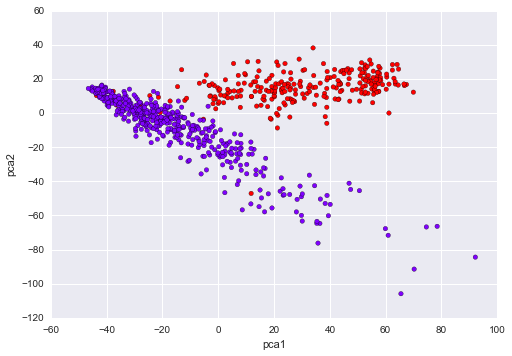

In [9]:
usertype = hourly.index.get_level_values('usertype')
weekday = hourly.index.get_level_values('date').dayofweek < 5
hourly['commute'] = (weekday & (usertype == "Annual Member"))

hourly.plot('pca1', 'pca2', c='commute', kind='scatter', 
            cmap='rainbow', colorbar=False);

In [10]:
mismatch = hourly.query('cluster == 0 & commute')
mismatch = mismatch.reset_index('usertype')[['usertype']]
mismatch

hour,usertype
date,
2014-10-13,Annual Member
2014-11-27,Annual Member
2014-11-28,Annual Member
2014-12-23,Annual Member
2014-12-24,Annual Member
2014-12-25,Annual Member
2014-12-26,Annual Member
2014-12-31,Annual Member
2015-01-01,Annual Member


In [11]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2014-08', '2015-10', return_name=True)
holidays_all = pd.concat([holidays,
                          "2 Days Before " + holidays.shift(-2, 'D'),
                          "Day Before " + holidays.shift(-1, 'D'),
                          "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head()

2014-08-30       2 Days Before Labor Day
2014-08-31          Day Before Labor Day
2014-09-01                     Labor Day
2014-09-02           Day After Labor Day
2014-10-11    2 Days Before Columbus Day
dtype: object

In [12]:
holidays_all.name = 'holiday name'  # required for join
joined = mismatch.join(holidays_all)
joined['holiday name']

date
2014-10-13                Columbus Day
2014-11-27                Thanksgiving
2014-11-28      Day After Thanksgiving
2014-12-23     2 Days Before Christmas
2014-12-24        Day Before Christmas
2014-12-25                   Christmas
2014-12-26         Day After Christmas
2014-12-31    Day Before New Years Day
2015-01-01               New Years Day
2015-05-25                 MemorialDay
2015-07-03                    July 4th
2015-09-07                   Labor Day
Name: holiday name, dtype: object

In [13]:
set(holidays) - set(joined['holiday name'])

{'Dr. Martin Luther King Jr.', 'Presidents Day', 'Veterans Day'}